<a href="https://colab.research.google.com/github/shuvad23/image-classification-projects/blob/main/Facial_Emotion_Recognition_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Emotion Detector CNN
- Project Description

  - The Emotion Detector CNN is a deep learning–based computer vision system designed to automatically recognize human facial emotions from images. The model classifies facial expressions into predefined emotion categories such as Happy, Sad, Angry, Fear, and Neutral using a Convolutional Neural Network (CNN).

  - The system leverages PyTorch for model development, TorchVision for dataset handling and transformations, and OpenCV for face detection and real-time image preprocessing. The project is trained and evaluated on the Facial Emotion Recognition Dataset from Kaggle.


  Dataset: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
  

System Architecture Overview

- The architecture consists of four major stages:

    - Image Acquisition & Preprocessing

    - CNN Feature Extraction

    - Fully Connected Classification

    - Emotion Prediction

🧠 1. What Your Project Is

    Project Type: Image Classification (Real-time via Webcam)
    Model: Custom CNN (PyTorch)
    Input: RGB image (IMG_SIZE × IMG_SIZE)
    Output: Class label + confidence
    Dataset Loader: ImageFolder
    Inference: OpenCV Webcam

🧱 2. CNN Architecture View

    📐 Input
        Input Image → (3, IMG_SIZE, IMG_SIZE)
        Example: (3, 64, 64)

    🔹 Feature Extractor (self.features)
        Conv2d(3 → 16, 3×3) + BN + ReLU
        MaxPool2d(2)
        ↓
        Conv2d(16 → 32, 3×3) + BN + ReLU
        MaxPool2d(2)
        ↓
        Conv2d(32 → 64, 3×3) + BN + ReLU
        MaxPool2d(2)
    📉 Spatial Size Reduction

        64 × 64
        → 32 × 32
        → 16 × 16
        → 8 × 8

    📦 Final Feature Map

      (64, 8, 8)


🔹 Classifier (self.classifier)

    Flatten → 64 × 8 × 8 = 4096
    ↓
    Linear(4096 → 128) + ReLU
    ↓
    Dropout(0.5)
    ↓
    Linear(128 → num_classes)



| Layer        | Output Shape     |
| ------------ | ---------------- |
| Input        | (B, 3, 64, 64)   |
| Conv1 + Pool | (B, 16, 32, 32)  |
| Conv2 + Pool | (B, 32, 16, 16)  |
| Conv3 + Pool | (B, 64, 8, 8)    |
| Flatten      | (B, 4096)        |
| FC1          | (B, 128)         |
| FC2          | (B, num_classes) |


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import cv2
import time

In [ ]:
#Configuration

DATA_DIR = '/content/data/processed_data'
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.002
VAL_SPLIT = 0.2
MODEL_PATH = "./model.pth"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)

        )
        self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(4096, 128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [ ]:
import zipfile
import os
zip_path = '/content/Facial-emotion-recognition-data.zip'
extract_path = '/content/data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

In [ ]:
len(full_dataset)

49779

In [ ]:
class_name = full_dataset.classes
num_classes = len(class_name)
print(class_name)
print(num_classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
7


In [ ]:
val_count = int(len(full_dataset)*VAL_SPLIT)
train_count = len(full_dataset) - val_count

train, val = random_split(full_dataset, [train_count, val_count])

In [ ]:
train_count,val_count

(39824, 9955)

In [ ]:
val.dataset.transform = test_transform

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train_model():
    global best_acc, EPOCHS, MODEL_PATH, IMG_SIZE # Access global variables
    best_acc = 0.0 # Initialize best_acc for this training run
    for epoch in range(EPOCHS):
        model.train()
        avg_loss = 0.0
        avg_correct = 0
        total = 0
        t0 = time.time()
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking = True), labels.to(device, non_blocking = True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()*images.size(0)
            preds = outputs.argmax(dim = 1)
            avg_correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        # evalution loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images,labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()*images.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += images.size(0)
        avg_loss /= total
        avg_acc = avg_correct/total
        val_loss /= val_total
        val_acc = val_correct/val_total
        t1 = time.time()
        elapsed = t1-t0
        print(f"EPOCH {epoch+1}/{EPOCHS}  train_loss={avg_loss:.3f} train_acc={avg_acc:.3f}  val_loss={val_loss:.3f} val_acc={val_acc:.3f}  time={elapsed:.1f}s")

        if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              "model_state" : model.state_dict(),
              "class_names" : class_name,
              "epoch" : epoch,
              "img_size" : IMG_SIZE
          }, MODEL_PATH)

          print(f"Saving the model with the best validation accuracy : {best_acc:.3f} to {MODEL_PATH}")

print("Training completed")

Training completed


In [ ]:
train_model()

EPOCH 1/50  train_loss=1.751 train_acc=0.287  val_loss=1.555 val_acc=0.400  time=38.8s
Saving the model with the best validation accuracy : 0.400 to ./model.pth
EPOCH 2/50  train_loss=1.641 train_acc=0.336  val_loss=1.486 val_acc=0.419  time=38.7s
Saving the model with the best validation accuracy : 0.419 to ./model.pth
EPOCH 3/50  train_loss=1.596 train_acc=0.358  val_loss=1.464 val_acc=0.455  time=38.8s
Saving the model with the best validation accuracy : 0.455 to ./model.pth
EPOCH 4/50  train_loss=1.546 train_acc=0.386  val_loss=1.389 val_acc=0.487  time=39.1s
Saving the model with the best validation accuracy : 0.487 to ./model.pth
EPOCH 5/50  train_loss=1.518 train_acc=0.398  val_loss=1.318 val_acc=0.511  time=38.7s
Saving the model with the best validation accuracy : 0.511 to ./model.pth
EPOCH 6/50  train_loss=1.495 train_acc=0.403  val_loss=1.300 val_acc=0.512  time=38.6s
Saving the model with the best validation accuracy : 0.512 to ./model.pth
EPOCH 7/50  train_loss=1.471 train

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def infer_image(image_path):
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    model.to(device)
    model.eval()

    class_names = checkpoint["class_names"]

    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, idx = torch.max(probs, dim=1)

    label = class_names[idx.item()]
    confidence = conf.item()

    plt.imshow(image)
    plt.title(f"{label} ({confidence:.2f})")
    plt.axis("off")


Saving images (2).jfif to images (2).jfif


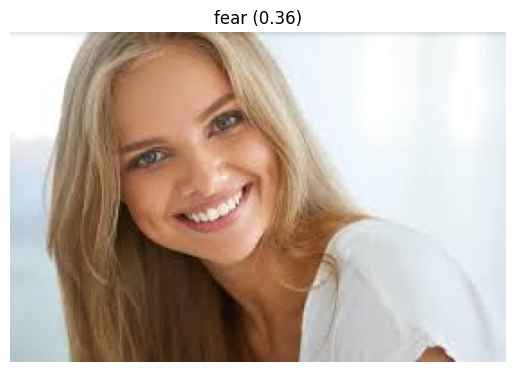

In [ ]:
# Upload Image in Colab
from google.colab import files
uploaded = files.upload()

# Get the filename from the uploaded dictionary (assuming only one file is uploaded)
if uploaded:
    first_filename = list(uploaded.keys())[0]
    infer_image(first_filename)
else:
    print("No file was uploaded.")